<a href="https://colab.research.google.com/github/HamidBekamiri/Econometrics-II/blob/main/09_Time_Series_Prediction_Using_Transformer_Models_for_TSLA_Stock_Prices_in_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Installing needed packages for the project

install.packages(c(
  "keras3", "tensorflow", "fredr", "gridExtra", "rsample", "dplyr", "quantmod"
))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘RcppTOML’, ‘here’, ‘png’, ‘future’, ‘globals’, ‘warp’, ‘reticulate’, ‘tfruns’, ‘zeallot’, ‘config’, ‘tfautograph’, ‘furrr’, ‘slider’




[1] "TSLA"

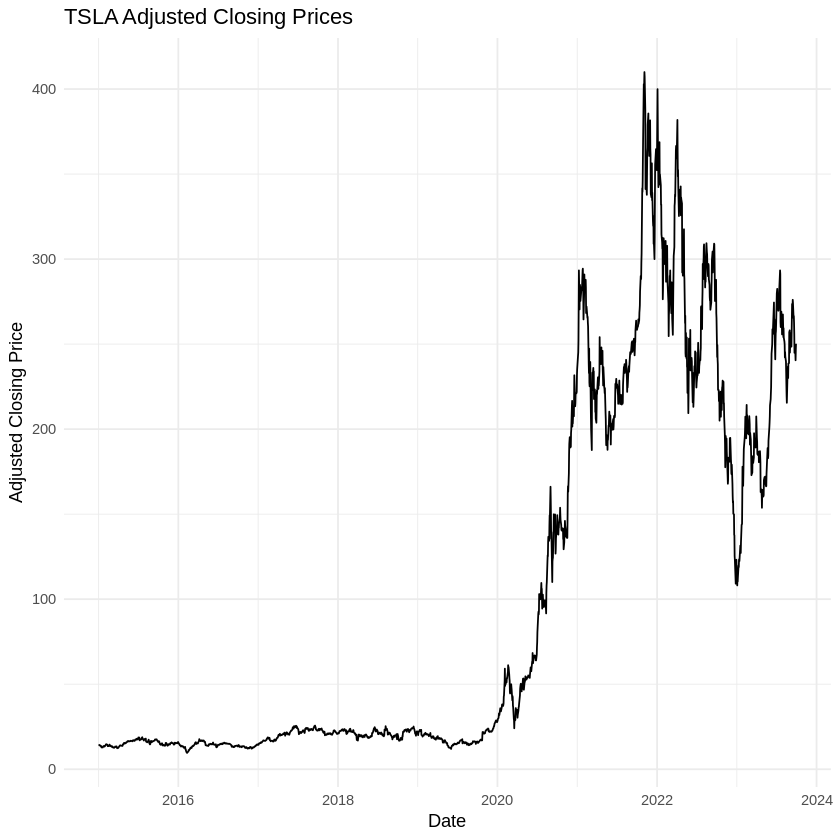

In [5]:
# Time Series Prediction Using Transformer Models for TSLA Stock Prices in R

# This example demonstrates how to perform time series prediction using a Transformer model in R with Keras and TensorFlow. We will predict future TSLA stock prices based on historical data.

# Introduction
# The Transformer architecture, introduced in the paper "Attention Is All You Need", has revolutionized natural language processing tasks. Here, we apply the Transformer architecture to time series data, specifically for predicting TSLA stock prices.

# Prerequisites
# TensorFlow 2.4 or higher
# Keras
# quantmod

# Load the Libraries
library(tensorflow)
library(keras3)
library(quantmod)
library(dplyr)
library(tidyr)
library(ggplot2)
set.seed(1234)

# Load and Preprocess the TSLA Stock Data
# We will use the quantmod package to fetch TSLA stock data from Yahoo Finance.

# Set the time period for historical data
start_date <- as.Date("2015-01-01")
end_date <- as.Date("2023-10-01")

# Get TSLA stock data
getSymbols("TSLA", src = "yahoo", from = start_date, to = end_date)

# Extract the adjusted closing prices
tsla_prices <- Cl(TSLA)

# Visualize the Closing Prices
# Plot the adjusted closing prices
autoplot(tsla_prices) +
  labs(title = "TSLA Adjusted Closing Prices",
       x = "Date",
       y = "Adjusted Closing Price") +
  theme_minimal()

# Prepare the Dataset
# We will create sequences of past prices to predict future prices. Let's use a window size of 60 days (approximately 3 months of trading days) to predict the next day's price.

# Convert the prices to a numeric vector
prices <- as.numeric(tsla_prices)

# Define the window size
window_size <- 60

# Function to create sequences
create_sequences <- function(data, window_size) {
  X <- list()
  y <- list()
  for (i in 1:(length(data) - window_size)) {
    X[[i]] <- data[i:(i + window_size - 1)]
    y[[i]] <- data[i + window_size]
  }
  return(list(
    X = array(unlist(X), dim = c(length(X), window_size, 1)),
    y = array(unlist(y), dim = c(length(y), 1))
  ))
}

# Create sequences
sequences <- create_sequences(prices, window_size)
X <- sequences$X
y <- sequences$y

# Split into training and testing sets (80% train, 20% test)
train_size <- floor(0.8 * dim(X)[1])
X_train <- X[1:train_size, , ]
y_train <- y[1:train_size]
X_test <- X[(train_size + 1):dim(X)[1], , ]
y_test <- y[(train_size + 1):dim(y)[1]]

# Normalize the Data
# Normalization is important for neural network models to converge faster.

# Calculate mean and standard deviation from the training data
train_mean <- mean(X_train)
train_sd <- sd(X_train)

# Normalize the datasets
X_train <- (X_train - train_mean) / train_sd
X_test <- (X_test - train_mean) / train_sd
y_train <- (y_train - train_mean) / train_sd
y_test <- (y_test - train_mean) / train_sd

# Build the Transformer Model
# Our model processes tensors of shape (batch_size, sequence_length, features), where:
# batch_size is the number of samples in each batch.
# sequence_length is the number of time steps (window size).
# features is the number of input features (1 in this case).
# We will adjust the model for regression by changing the output layer to have one neuron with linear activation.


In [7]:
library(tensorflow)
library(keras3)
library(quantmod)
library(xts)
library(dplyr)
library(ggplot2)

# Load TSLA data using quantmod
getSymbols("TSLA", src = "yahoo",
           from = Sys.Date() - 2017,
           to = Sys.Date(),
           auto.assign = FALSE) -> indf_data
indf_data <- na.omit(indf_data)

# Add technical indicators
indf_data$SMA20 <- SMA(Cl(indf_data), n = 20)
indf_data$SMA50 <- SMA(Cl(indf_data), n = 50)
indf_data$RSI <- RSI(Cl(indf_data))
indf_data$MACD <- MACD(Cl(indf_data))[,1]
indf_data$BBands <- BBands(Cl(indf_data))[,1]
indf_data$ADX <- ADX(indf_data[,c("TSLA.High","TSLA.Low","TSLA.Close")])[,1]

# Prepare data matrix
feature_cols <- c("TSLA.Open", "TSLA.High", "TSLA.Low", "TSLA.Close", "TSLA.Volume",
                 "SMA20", "SMA50", "RSI", "MACD", "BBands", "ADX")
data_matrix <- as.matrix(na.omit(indf_data[, feature_cols]))

# Normalize data
normalize_data <- function(x) {
  return((x - min(x)) / (max(x) - min(x)))
}

data_normalized <- apply(data_matrix, 2, normalize_data)

# Function to create sequences with multiple features
create_sequences <- function(data, seq_length) {
  x <- list()
  y <- list()

  for(i in 1:(nrow(data) - seq_length)) {
    x[[i]] <- data[i:(i + seq_length - 1), ]
    y[[i]] <- data[i + seq_length, 4]  # Close price
  }

  list(
    x = array(unlist(x), dim = c(length(x), seq_length, ncol(data))),
    y = unlist(y)
  )
}


In [8]:
# Create sequences
seq_length <- 60
split_idx <- floor(nrow(data_normalized) * 0.8)
train_data <- data_normalized[1:split_idx,]
test_data <- data_normalized[(split_idx + 1):nrow(data_normalized),]

# Create training and testing sequences
train_sequences <- create_sequences(train_data, seq_length)
test_sequences <- create_sequences(test_data, seq_length)

# Fixed transformer encoder block
transformer_encoder <- function(inputs,
                              head_size,
                              num_heads,
                              ff_dim,
                              dropout = 0) {
  # Multi-head self attention
  attention <- layer_multi_head_attention(
    num_heads = num_heads,
    key_dim = head_size
  )
  x <- inputs
  attn_output <- attention(inputs, value = inputs)
  attn_output <- layer_dropout(rate = dropout)(attn_output)
  out1 <- layer_layer_normalization(epsilon = 1e-6)(attn_output + inputs)

  # Feed-forward network
  ffn <- keras_model_sequential() %>%
    layer_dense(units = ff_dim, activation = "relu") %>%
    layer_dense(units = shape(inputs)[[3]])

  ffn_output <- ffn(out1)
  ffn_output <- layer_dropout(rate = dropout)(ffn_output)
  return(layer_layer_normalization(epsilon = 1e-6)(ffn_output + out1))
}

# Build model with fixed attention mechanism
build_model <- function(input_shape,
                       head_size,
                       num_heads,
                       ff_dim,
                       num_transformer_blocks,
                       mlp_units,
                       dropout = 0,
                       mlp_dropout = 0) {

  inputs <- layer_input(shape = input_shape)
  x <- inputs

  # Transformer blocks
  for(i in 1:num_transformer_blocks) {
    x <- transformer_encoder(
      x,
      head_size = head_size,
      num_heads = num_heads,
      ff_dim = ff_dim,
      dropout = dropout
    )
  }

  # Global average pooling
  x <- layer_global_average_pooling_1d()(x)

  # Final MLP layers
  for(dim in mlp_units) {
    x <- x %>%
      layer_dense(units = dim, activation = "relu") %>%
      layer_batch_normalization() %>%
      layer_dropout(rate = mlp_dropout)
  }

  outputs <- layer_dense(x, units = 1)

  keras_model(inputs, outputs)
}

# Create and compile model
input_shape <- c(seq_length, ncol(data_normalized))
model <- build_model(
  input_shape = input_shape,
  head_size = 256,
  num_heads = 4,
  ff_dim = 4,
  num_transformer_blocks = 4,
  mlp_units = c(128, 64),
  mlp_dropout = 0.4,
  dropout = 0.25
)

# Compile model
model %>% compile(
  optimizer = optimizer_adam(learning_rate = 1e-4),
  loss = "mse",
  metrics = c("mae")
)

In [10]:
# Updated callbacks with correct file extension
callbacks <- list(
  callback_early_stopping(
    monitor = "val_loss",
    patience = 15,
    restore_best_weights = TRUE
  ),
  callback_reduce_lr_on_plateau(
    monitor = "val_loss",
    factor = 0.5,
    patience = 5,
    min_lr = 1e-6
  ),
  callback_model_checkpoint(
    filepath = "best_model.keras",  # Changed from .h5 to .keras
    save_best_only = TRUE,
    monitor = "val_loss"
  )
)

# Train the model
history <- model %>% fit(
  x = train_sequences$x,
  y = train_sequences$y,
  epochs = 100,
  batch_size = 32,
  validation_split = 0.2,
  callbacks = callbacks,
  verbose = 1
)

In [16]:
# Make predictions
predictions <- model %>% predict(test_sequences$x)

# Denormalize predictions and actual values
close_price_idx <- which(feature_cols == "TSLA.Close")
original_close <- data_matrix[, close_price_idx]
predictions_denorm <- predictions * (max(original_close) - min(original_close)) + min(original_close)
actual_denorm <- test_sequences$y * (max(original_close) - min(original_close)) + min(original_close)

# Calculate metrics
mse <- mean((predictions_denorm - actual_denorm)^2)
rmse <- sqrt(mse)
mae <- mean(abs(predictions_denorm - actual_denorm))
mape <- mean(abs((actual_denorm - predictions_denorm) / actual_denorm)) * 100

# Print metrics
cat("\nModel Performance Metrics:\n")
cat("Root Mean Square Error:", rmse, "\n")
cat("Mean Absolute Error:", mae, "\n")
cat("Mean Absolute Percentage Error:", mape, "%\n")

# Calculate directional accuracy
direction_actual <- sign(diff(actual_denorm))
direction_pred <- sign(diff(predictions_denorm))
directional_accuracy <- mean(direction_actual == direction_pred, na.rm = TRUE) * 100
cat("Directional Accuracy:", directional_accuracy, "%\n")


Model Performance Metrics:
Root Mean Square Error: 118.7889 
Mean Absolute Error: 115.0104 
Mean Absolute Percentage Error: 55.78042 %
Directional Accuracy: 52.88462 %


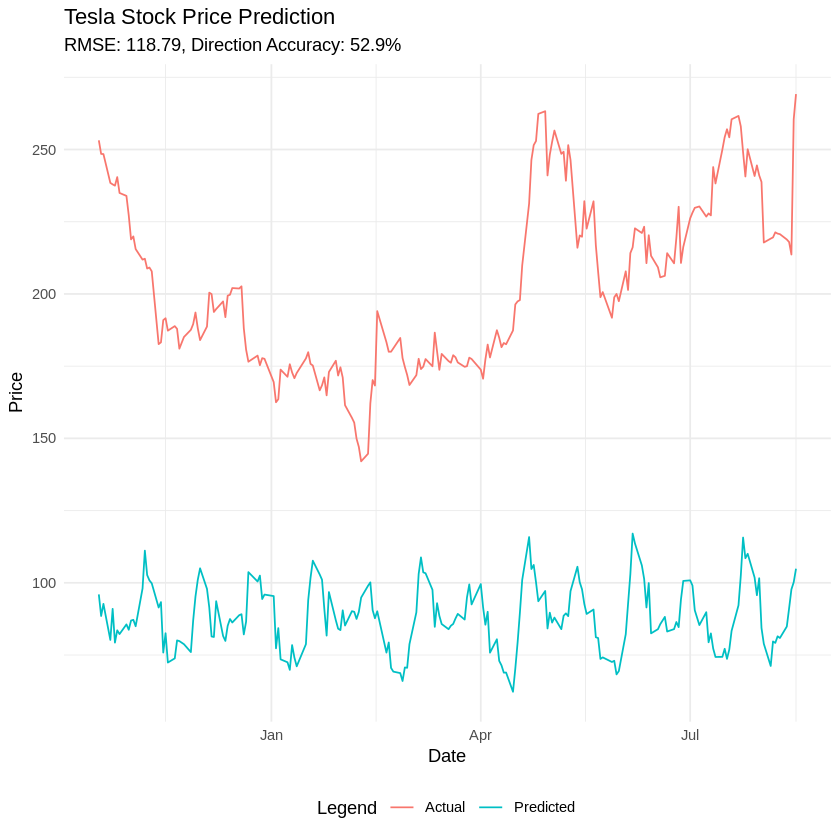

In [20]:
# Plot results
dates <- index(indf_data)[(split_idx + seq_length + 1):(split_idx + seq_length + length(actual_denorm))]
plot_data <- data.frame(
  Date = dates,
  Actual = actual_denorm,
  Predicted = predictions_denorm
)

# Create ggplot visualization
p <- ggplot(plot_data, aes(x = Date)) +
  geom_line(aes(y = Actual, color = "Actual")) +
  geom_line(aes(y = Predicted, color = "Predicted")) +
  labs(title = "Tesla Stock Price Prediction",
       subtitle = sprintf("RMSE: %.2f, Direction Accuracy: %.1f%%", rmse, directional_accuracy),
       y = "Price",
       color = "Legend") +
  theme_minimal() +
  theme(legend.position = "bottom")

print(p)